In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.optimize import curve_fit
import mplhep as hep
hep.style.use("LHCb2")

np.random.seed(42)

#read the data from the csv file
data = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')
data_plus = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')

In [14]:
BINS = 150


In [15]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * halfnorm.cdf(x, mu, sigma)
    # result = np.zeros(len(x))
    # result = np.where(x > 5100, n * norm.cdf(x, mu, sigma), 0)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)

@jit
def cdf(x, norm_mu, norm_sigma, norm_n,
        comb_mu, comb_sigma, comb_n,
        tau, xoffset, norm,
        total_norm):
    
    signal_result = signal(x, norm_mu, norm_sigma, norm_n)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)

    return popt, pcov

In [16]:
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bminus.csv", delimiter=",")

#take only data from 5100 to 5400
data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [17]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5200, 5400)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True


In [18]:
n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

/tmp/ipykernel_140568/1436018039.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf_crystal" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_140568/1436018039.py", line 40:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf_crystal" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_140568/1436018039.py", line 32:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readth

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 123.8 (χ²/ndof = 0.9)      │             Nfcn = 3705              │
│ EDM = 9.36e-08 (Goal: 0.0002)    │            time = 5.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.200   │   0.012   │            │            │         │         │  yes  │
│ 1 │ crystal_m     │    2.4    │    0.4    │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28425e3 │ 0.00026e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   19.95   │   0.28    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │  1.08e3   │  0.06e3   │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   38.9    │    1.4    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    317    │    19     │            │            │    1    │  10000  │       │
│ 8 │ tau           │  1.858e3  │  0.024e3  │            │            │         │         │       │
│ 9 │ xoffset       │  13.16e3  │  0.12e3   │            │            │         │         │       │
│ 10│ norm          │    150    │    10     │            │            │         │         │       │
│ 11│ total_norm    │   17.4    │    0.9    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0          0.00          0.00          0.00             0             0             0             0             0             0             0           0.0 │
│     crystal_m │          0.00          0.15         -0.03          0.03         -8.48          0.00          0.35          3.29         -0.68         -0.35         -0.03         -0.02 │
│   crystal_loc │          0.00         -0.03        0.0678         -0.02          1.33          0.00         -0.05         -0.50         -0.01         -0.14         -0.01          0.00 │
│ crystal_scale │          0.00          0.03         -0.02        0.0761         -0.53          0.00          0.06          0.69          0.29          0.27          0.02          0.00 │
│  crystal_norm │             0         -8.48          1.33         -0.53      3.36e+03             0         -20.7         0.6e3        -0.2e3         1.7e3           130 

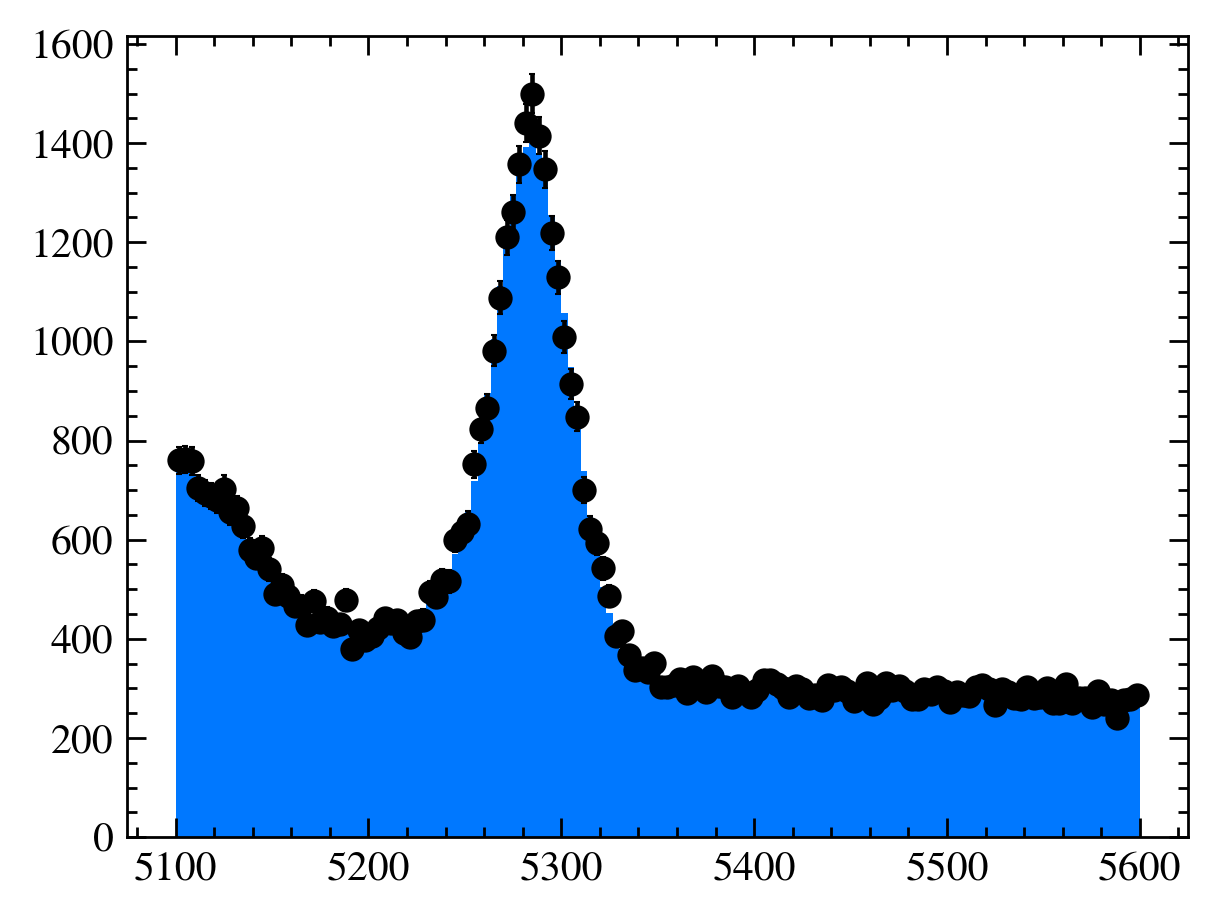

In [19]:
n_plus_c.hesse()

In [20]:
n_plus_c.values

<ValueView crystal_beta=1.2 crystal_m=2.4491190306769393 crystal_loc=5284.250212377747 crystal_scale=19.94963198702606 crystal_norm=1076.8723356640517 comb_mu=5100.0 comb_sigma=38.90749692926925 comb_n=316.9563513088875 tau=1857.8292054980038 xoffset=13160.14936971316 norm=149.69932839489556 total_norm=17.404013924251117>

In [21]:
# array_p0_crystal =  np.array(  [1.2, 2.4291907701608824, 5284.267685204268,
#                                     19.918442543457957,1279.8439838197178,
#                                     5100, 38.67940884398665, 374.9137222528735, 1846.0075652051228, 5448.5,
#                                     1459, 114.939])

#extract the p0 values from the fitting of n_plus_c
array_p0_crystal = np.array([n_plus_c.values['crystal_beta'],
                            n_plus_c.values['crystal_m'],
                            n_plus_c.values['crystal_loc'],
                            n_plus_c.values['crystal_scale'],
                            n_plus_c.values['crystal_norm'],
                            n_plus_c.values['comb_mu'],
                            n_plus_c.values['comb_sigma'],
                            n_plus_c.values['comb_n'],
                            n_plus_c.values['tau'],
                            n_plus_c.values['xoffset'],
                            n_plus_c.values['norm'],
                            n_plus_c.values['total_norm']])
# print(array_p0_crystal)

n_plus_c.values['tau'] = 2100
epsilon = 1000
upper_crystal = array_p0_crystal + epsilon
lower_crystal = array_p0_crystal - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = array_p0_crystal[0] - 3e-1
upper_crystal[0] = array_p0_crystal[0] + 3e-1

upper_crystal[1] = array_p0_crystal[1] + 3e-1
lower_crystal[1] = array_p0_crystal[1] - 3e-1

upper_crystal[2] = array_p0_crystal[2] + 10
lower_crystal[2] = array_p0_crystal[2] - 10

upper_crystal[3] = array_p0_crystal[3] + 3e-1
lower_crystal[3] = array_p0_crystal[3] - 3e-1


upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8


In [22]:
def fit_curve_post_minut_bounded(data, p0_vals, upper, lower):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    unc_vals = np.sqrt(bin_heihgts)

    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts,
                            p0=p0_vals, bounds=(lower, upper),
                            sigma=unc_vals, absolute_sigma=True)
    plt.clf()
    return popt, pcov

# Using this sub to curve_fit

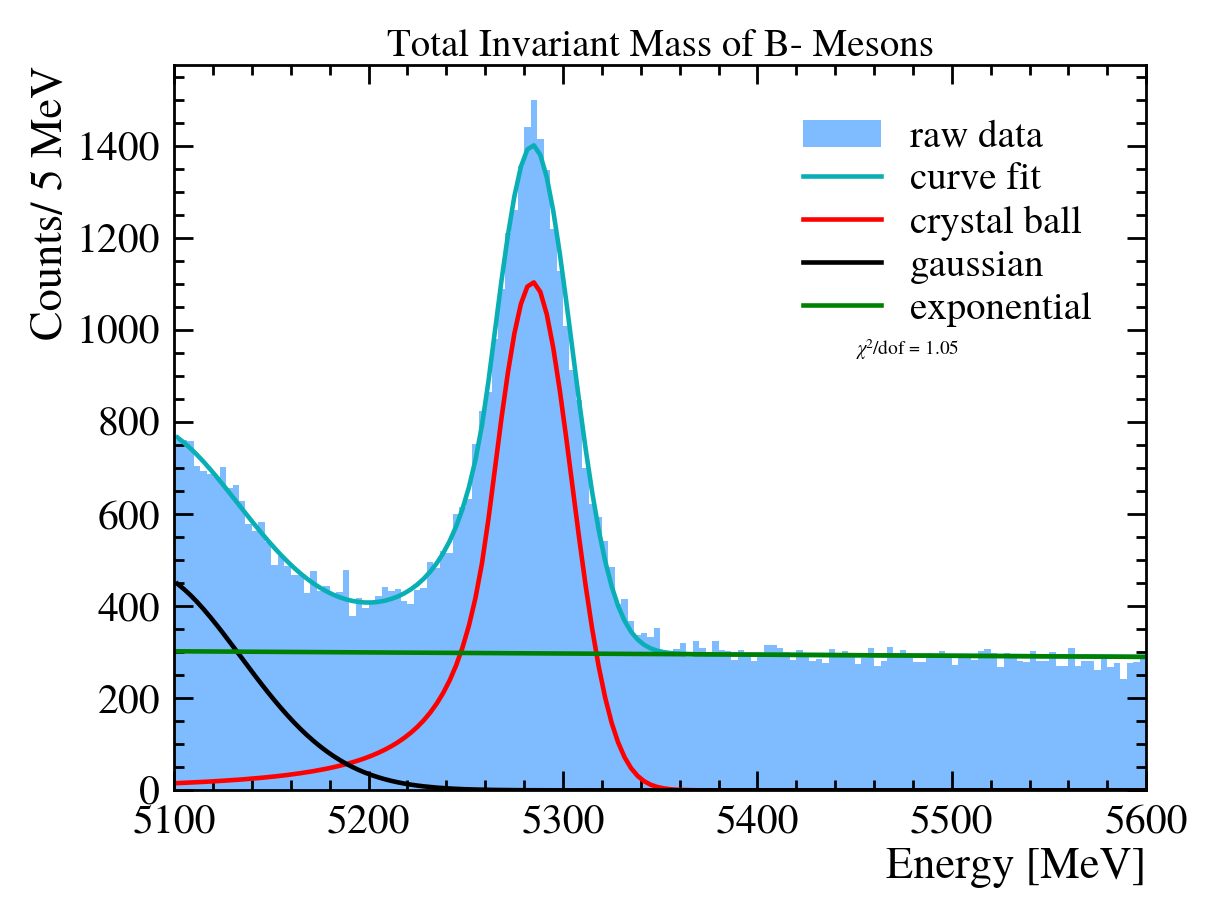

In [23]:
# popt, pcov = fit_curve_post_minut(data_plus, 
#                                   [1.2, 3.066800708293673, 5283.866200116772,
#                                     20.679652920238063,160.86015229246274,
#                                     5100, 39.65547, 49.60, 1790.5, 5448.5,
#                                     1459, 114.939])

popt, pcov = fit_curve_post_minut_bounded(data_plus, array_p0_crystal, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")
plt.xlim(5100, 5600)

plt.legend()

In [24]:
#print popt with the name of the parameter
for i, name in enumerate(["crystal_beta", "crystal_m", "crystal_loc", "crystal_scale", "crystal_norm",
                            "comb_mu", "comb_sigma", "comb_n", "tau", "xoffset", "norm", "total_norm"]):
        print(name, popt[i])
    

crystal_beta 1.123116402333092
crystal_m 2.2835436746926985
crystal_loc 5284.335704835403
crystal_scale 20.249631987026056
crystal_norm 4054.86305856733
comb_mu 5082.606974805746
comb_sigma 51.4350362444756
comb_n 3719.5793503812206
tau 1862.450646849503
xoffset 12160.14937025486
norm 287763.6465711502
total_norm 16.65789258899917


Number of events:  65084.74405747599


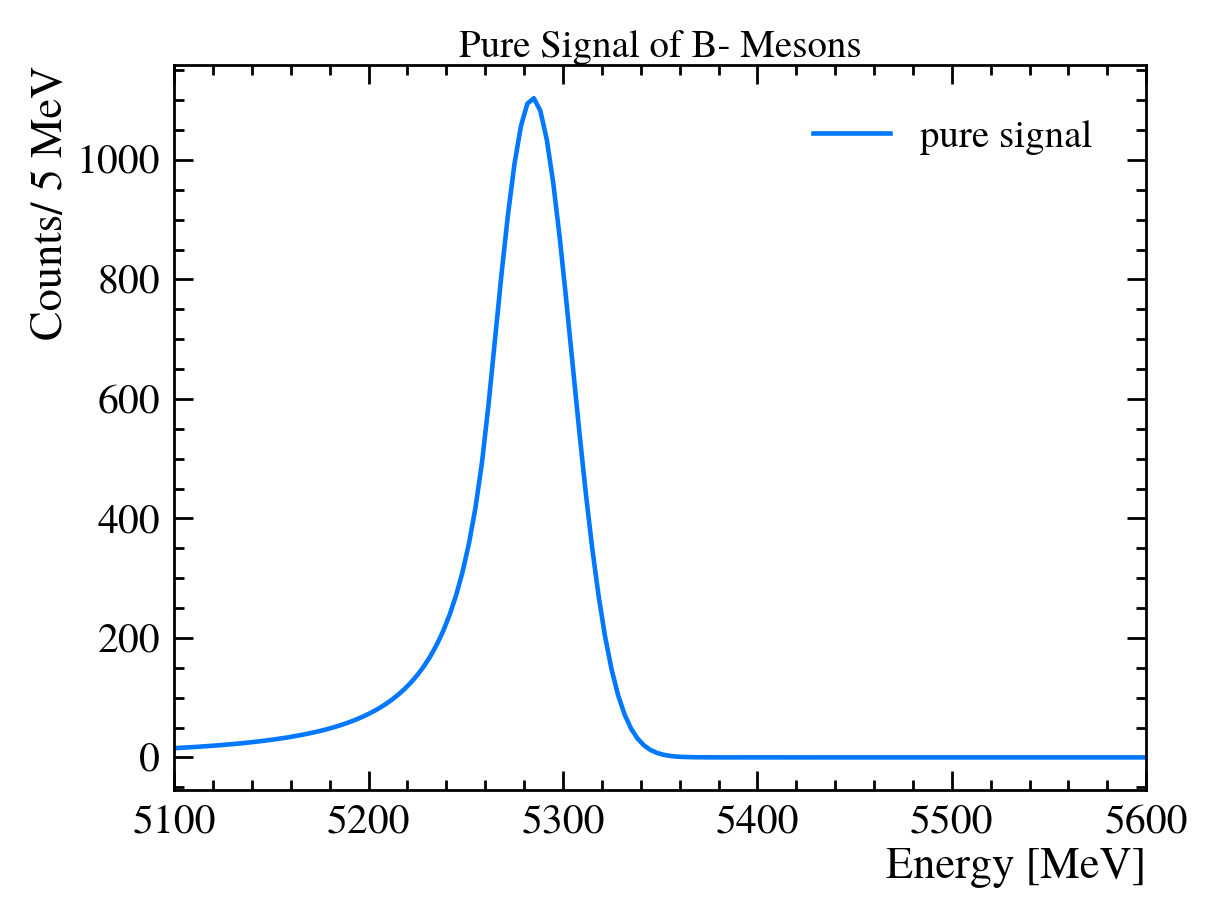

In [25]:
#subtract the background from the data
pure_signal = total_part - comb_part - exp_part

#plot the pure signal
plt.figure()
plt.plot(bin_centers, pure_signal, label="pure signal")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B- Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events = np.trapz(pure_signal, bin_centers)
print("Number of events: ", number_of_events)


# Testing Different signal functions

In [84]:

def fit_gaussian(x, signal_mu, signal_sigma, signal_norm,
                partial_mu, partial_sigma, partial_norm,
                tau, xoffset, exp_norm, 
                total_norm):
    
    signal_gaussian = norm.pdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.pdf(x, partial_mu, partial_sigma) * partial_norm
    exponential = expon.pdf(x, tau, xoffset) * exp_norm
    
    return (signal_gaussian + partial_gaussian + exponential) * total_norm

@jit
def minuit_gaussian(x, signal_mu, signal_sigma, signal_norm,
                    partial_mu, partial_sigma, partial_norm,
                    tau, xoffset, exp_norm,
                    total_norm):
    
    signal_gaussian = norm.cdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.cdf(x, partial_mu, partial_sigma) * partial_norm
    exponential = expon.cdf(x, tau, xoffset) * exp_norm

    return (signal_gaussian + partial_gaussian + exponential) * total_norm

def fit_gaussian_post_minut(data, p0_vals):
    hist_raw = plt.hist(data, bins=100, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA
    
    pot, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=p0_vals)
    plt.clf()
    return pot, pcov

In [85]:
c_crystal_signal = cost.ExtendedBinnedNLL(n_plus, xe_plus, minuit_gaussian)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [86]:
n_plus_gaussian_signal = Minuit(     c_crystal_signal,
                signal_mu=5100,
                signal_sigma=10,
                signal_norm=100,

                partial_mu=5100,
                partial_sigma=10,
                partial_norm=100,

                tau=1500,
                xoffset=4100,
                exp_norm=1e3,

                total_norm=1e2)
n_plus_gaussian_signal.limits['signal_sigma'] = (1, 50)
n_plus_gaussian_signal.limits['signal_norm'] = (1, 1e4)
n_plus_gaussian_signal.limits['signal_mu'] = (5200, 5400)

n_plus_gaussian_signal.limits['partial_sigma'] = (1, 50)
n_plus_gaussian_signal.limits['partial_norm'] = (1, 1e4)
n_plus_gaussian_signal.limits['partial_mu'] = (5100, 5101)

n_plus_gaussian_signal.limits['tau'] = (1, 1e4)

n_plus_gaussian_signal.fixed["partial_mu"] = True

In [87]:
n_plus_gaussian_signal.migrad(iterate=20, ncall=300000).migrad()
n_plus_gaussian_signal.interactive()

/tmp/ipykernel_67082/3072039654.py:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "minuit_gaussian" failed type inference due to: Untyped global name 'halfnorm': Cannot determine Numba type of <class 'scipy.stats._continuous_distns.halfnorm_gen'>

File "../../../../tmp/ipykernel_67082/3072039654.py", line 19:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "minuit_gaussian" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_67082/3072039654.py", line 12:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more inf

In [88]:
#print the values of the parameters after the fit in a nice way
n_plus_gaussian_signal.values

#parse it to an array
array_of_p0 = np.array([n_plus_gaussian_signal.values["signal_mu"],
                        n_plus_gaussian_signal.values["signal_sigma"],
                        n_plus_gaussian_signal.values["signal_norm"],
                        n_plus_gaussian_signal.values["partial_mu"],
                        n_plus_gaussian_signal.values["partial_sigma"],
                        n_plus_gaussian_signal.values["partial_norm"],
                        n_plus_gaussian_signal.values["tau"],
                        n_plus_gaussian_signal.values["xoffset"],
                        n_plus_gaussian_signal.values["exp_norm"],
                        n_plus_gaussian_signal.values["total_norm"]])


In [89]:
epsilon = 10

lower_array = array_of_p0 - epsilon
upper_array = array_of_p0 + epsilon



In [90]:
#free the normalisation parameter by setting lower_array for it to 0
lower_array[2] = 0
lower_array[5] = 0
lower_array[8] = 0
lower_array[9] = 0

#set the upper limit for the normalisation parameter to 1e4
upper_array[2] = 1e9
upper_array[5] = 1e9
upper_array[8] = 1e9
upper_array[9] = 1e9


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/minuit.py:2353: IMinuitWarning: Specified nsigma bound, but error matrix is not accurate
  warnings.warn(


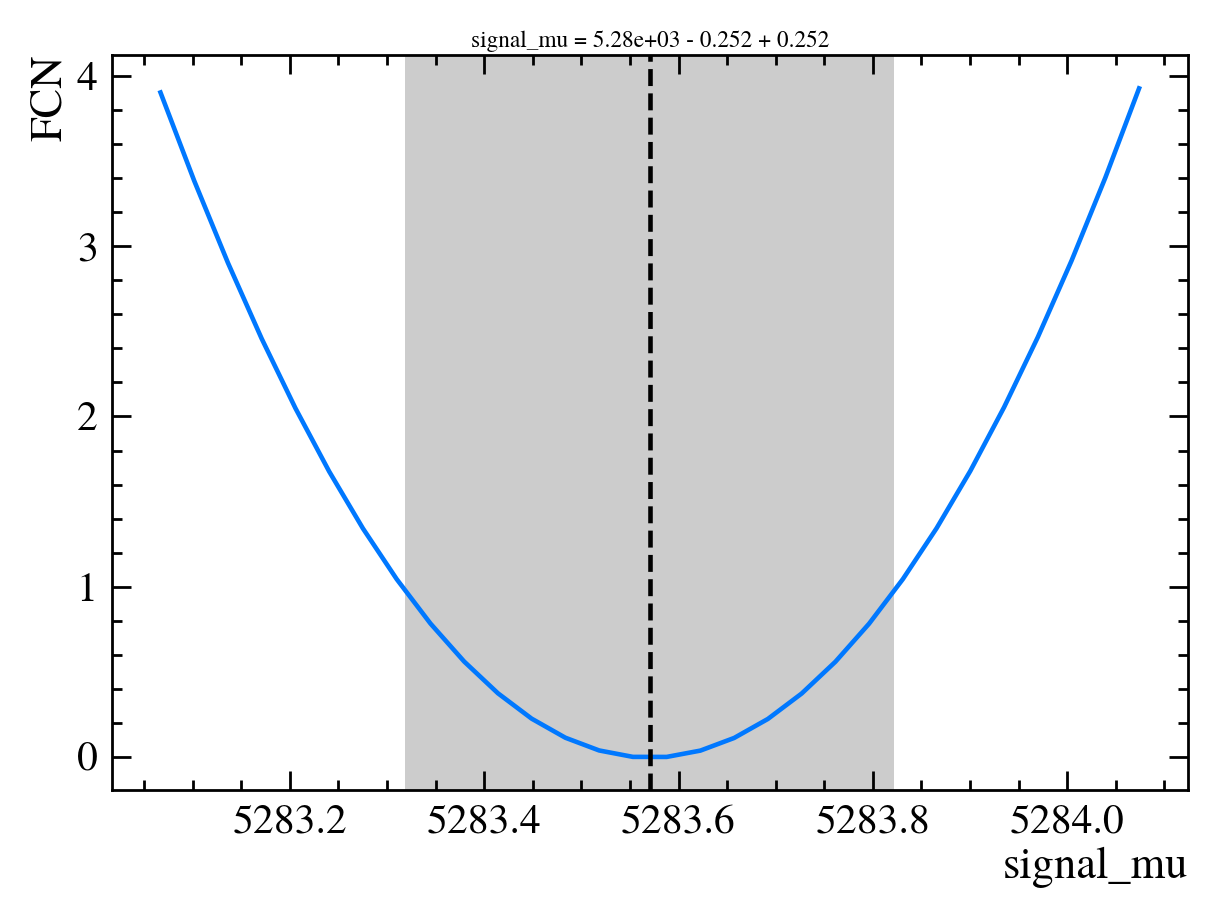

In [91]:
n_plus_gaussian_signal.draw_mnprofile("signal_mu", subtract_min=True);

# Fit the data using curve_fit


In [92]:
def fit_curve_bounds(data, p0_vals, lower_bound, upper_bound):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA

    pot, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=p0_vals, bounds=(lower_bound, upper_bound))
    plt.clf()
    return pot, pcov


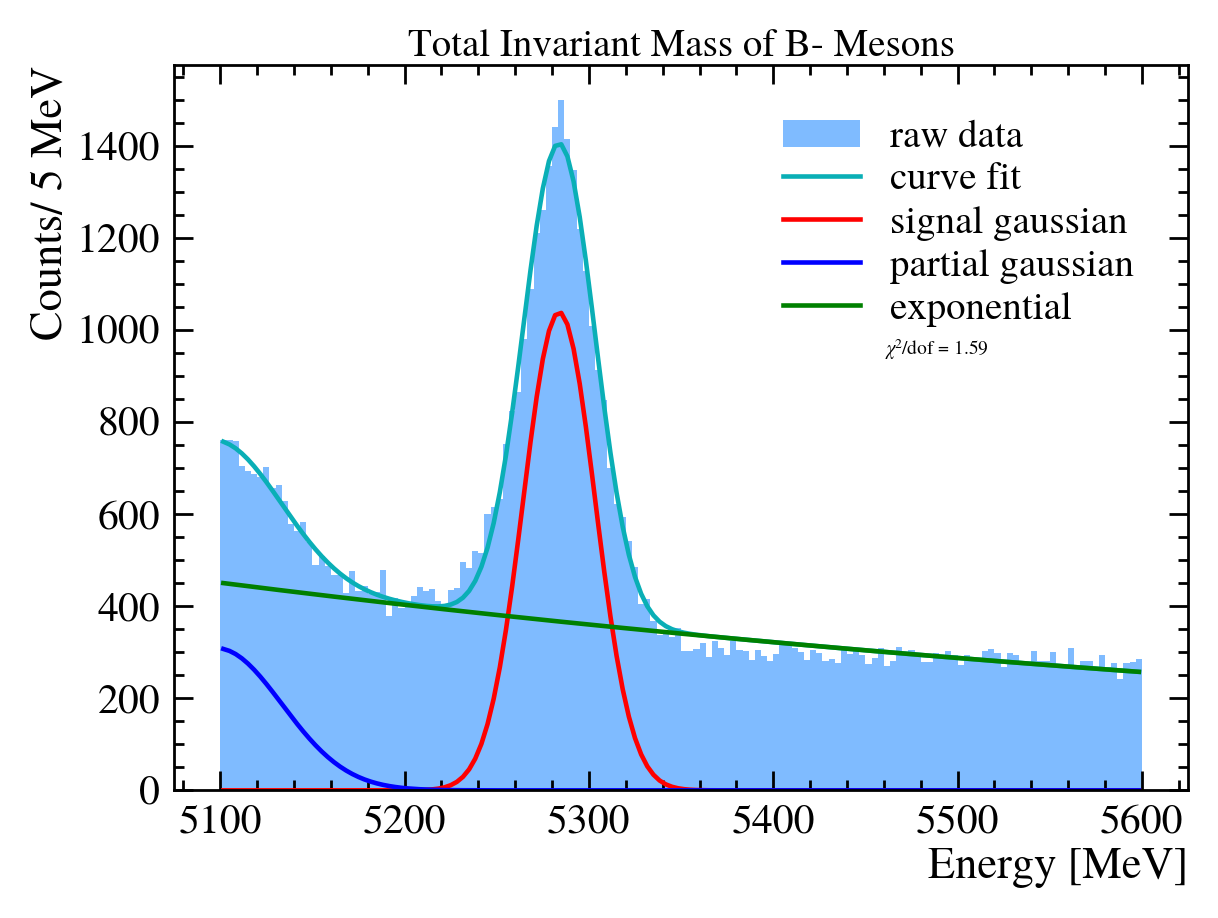

In [93]:
#popt, pcov = fit_gaussian_post_minut(data_plus, array_of_p0)

popt, pcov = fit_curve_bounds(data_plus, array_of_p0, lower_array, upper_array)
#trying with bounds 




#plot the data
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

#calculate the fit
signal_gaussian = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2] * popt[-1]
partial_gaussian = halfnorm.pdf(bin_centers, popt[3], popt[4]) * popt[5] * popt[-1]
exponential = expon.pdf(bin_centers, popt[6], popt[7]) * popt[8] * popt[-1]

total_signal_gausain = signal_gaussian + partial_gaussian + exponential
pure_signal_gaussian = total_signal_gausain - partial_gaussian - exponential


#plot the fit
plt.plot(bin_centers, fit_gaussian(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, signal_gaussian, label="signal gaussian", color="red")
plt.plot(bin_centers, partial_gaussian, label="partial gaussian", color="blue")
plt.plot(bin_centers, exponential, label="exponential", color="green")

#add labels
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_gaussian(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 1
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)

#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")

plt.legend()


Number of events:  50887.28007052895


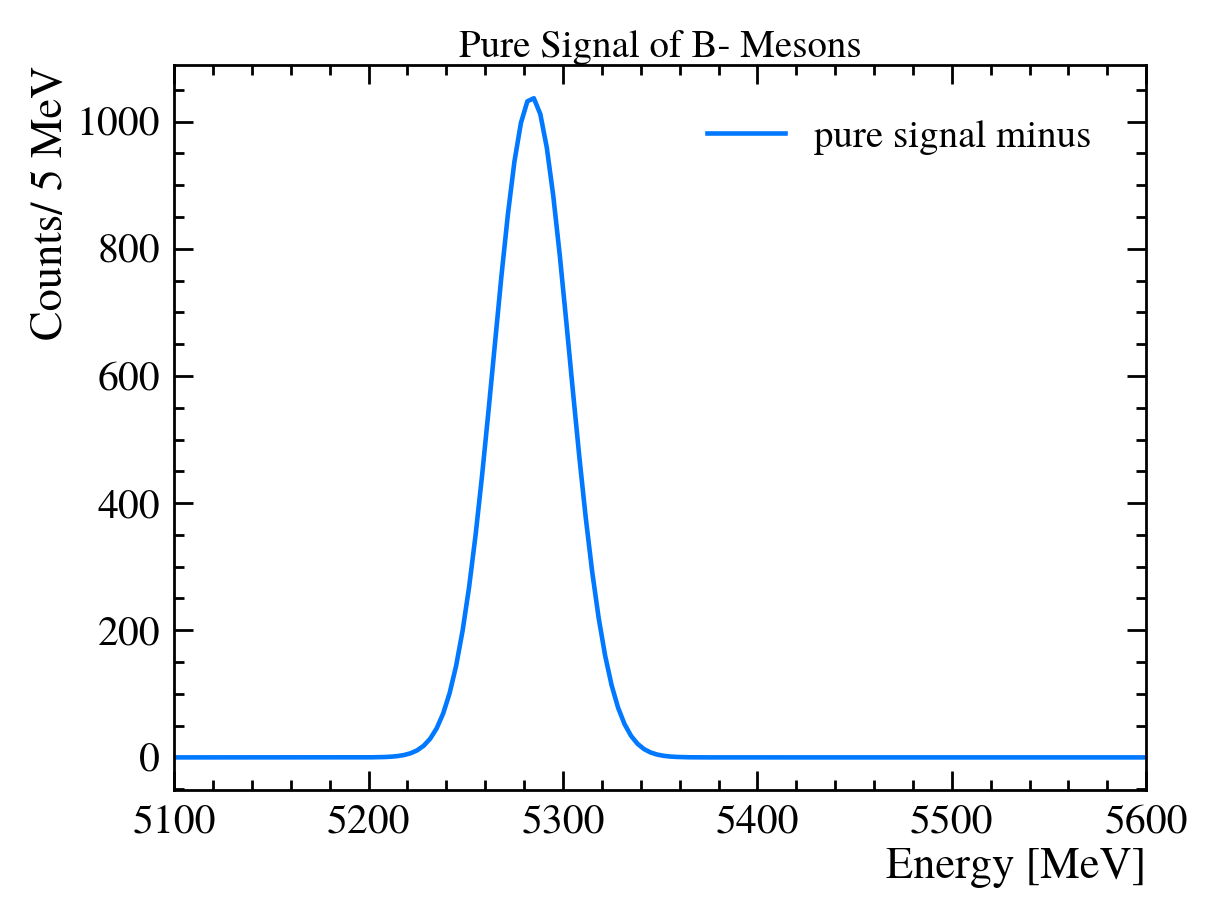

In [94]:
plt.figure()
plt.plot(bin_centers, pure_signal_gaussian, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B- Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_minus = np.trapz(pure_signal_gaussian, bin_centers)
print("Number of events: ", number_of_events_minus)

# Usinng Different Background functions

In [95]:
def linear_function(x, a, b):
    return a*x + b

def linear_cdf(x, a, b):
    return (a/2)*x**2 + b * x

In [96]:
def fit_gaussian_lin(x, signal_mu, signal_sigma, signal_norm,
                partial_mu, partial_sigma, partial_norm,
                a, b, lin_norm, 
                total_norm):
    
    signal_gaussian = norm.pdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.pdf(x, partial_mu, partial_sigma) * partial_norm
    linear = linear_function(x, a, b) * lin_norm
    
    return (signal_gaussian + partial_gaussian + linear) * total_norm

@jit
def minut_gauss_linear(x, signal_mu, signal_sigma, signal_norm,
                    partial_mu, partial_sigma, partial_norm,
                    a, b, lin_norm,
                    total_norm):
    
    signal_gaussian = norm.cdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.cdf(x, partial_mu, partial_sigma) * partial_norm
    linear = linear_cdf(x, a, b) * lin_norm

    return (signal_gaussian + partial_gaussian + linear) * total_norm

def fit_gaussian_lin_post_minut(data, p0_vals, lower_bound=None, upper_bound=None):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA
    
    if not lower_bound:
        popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals,
                               bounds=(lower_bound, upper_bound))
    else:
        popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals)
    plt.clf()
    return popt, pcov

In [97]:
c_gaussian_linear = cost.ExtendedBinnedNLL(n_plus, xe_plus, minut_gauss_linear)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [98]:
n_plus_gauss_linear = Minuit(c_gaussian_linear,
                                signal_mu=5300,
                                signal_sigma=10,
                                signal_norm=1000,

                                partial_mu=5100,
                                partial_sigma=60,
                                partial_norm=700,

                                a = -0.04,
                                b = 400,
                                lin_norm = 0.3,

                                total_norm=10,
)


# n_plus_gauss_linear.limits['signal_sigma'] = (1, 50)
# n_plus_gauss_linear.limits['signal_norm'] = (1, 1e4)
# n_plus_gauss_linear.limits['signal_mu'] = (5200, 5400)

# n_plus_gauss_linear.limits['partial_sigma'] = (1, 50)
# n_plus_gauss_linear.limits['partial_norm'] = (1, 1e4)
n_plus_gauss_linear.limits['partial_mu'] = (5100, 5101)

In [99]:
n_plus_gauss_linear.migrad(iterate=20, ncall=1000000)
n_plus_gauss_linear.interactive()

/tmp/ipykernel_67082/4266775779.py:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "minut_gauss_linear" failed type inference due to: Untyped global name 'halfnorm': Cannot determine Numba type of <class 'scipy.stats._continuous_distns.halfnorm_gen'>

File "../../../../tmp/ipykernel_67082/4266775779.py", line 19:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "minut_gauss_linear" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_67082/4266775779.py", line 12:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For mo

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 243.1 (χ²/ndof = 1.7)      │              Nfcn = 764              │
│ EDM = 4.74e-07 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal_mu     │ 5.28342e3 │ 0.00025e3 │            │            │         │         │       │
│ 1 │ signal_sigma  │   20.32   │   0.28    │            │            │         │         │       │
│ 2 │ signal_norm   │  1.60e3   │  0.08e3   │            │            │         │         │       │
│ 3 │ partial_mu    │ 5.1000e3  │ 0.0009e3  │            │            │  5100   │  5101   │       │
│ 4 │ partial_sigma │   38.4    │    1.8    │            │            │         │         │       │
│ 5 │ partial_norm  │    480    │    40     │            │            │         │         │       │
│ 6 │ a             │ -43.0e-3  │  0.4e-3   │            │            │         │         │       │
│ 7 │ b             │   274.8   │    2.6    │            │            │         │         │       │
│ 8 │ lin_norm      │   0.230   │   0.013   │            │            │         │         │       │
│ 9 │ total_norm    │    9.8    │    0.5    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │     signal_mu  signal_sigma   signal_norm    partial_mu partial_sigma  partial_norm             a             b      lin_norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     signal_mu │        0.0637         -0.01         -1.44       -0.8e-9         -0.04         -0.89      -7.06e-6         -0.02       0.26e-3          0.00 │
│  signal_sigma │         -0.01        0.0755          5.85        3.8e-9          0.16          3.38      22.62e-6          0.08      -0.90e-3         -0.02 │
│   signal_norm │         -1.44          5.85      6.43e+03      907.8e-9          40.7         2.4e3    4.95324e-3            36     450.56e-3        -35.22 │
│    partial_mu │       -0.8e-9        3.8e-9      907.8e-9      1.08e-09      228.1e-9     4.2532e-6             0       18.9e-9       -0.2e-9       -3.3e-9 │
│ partial_sigma │         -0.04          0.16          40.7      228.1e-9          3.41          41.3     219.43e-6           0.8      -8.39e-3         -0.16 │
│  partial_norm │         -0.89          3.38         2.4e3     4.2532e-6          41.3      1.31e+03    4.42591e-3            21      24.67e-3        -12.66 │
│             a │      -7.06e-6      22.62e-6    4.95324e-3             0     219.43e-6    4.42591e-3      1.94e-07    -819.07e-6      -0.95e-6     -17.61e-6 │
│             b │         -0.02          0.08            36       18.9e-9           0.8 

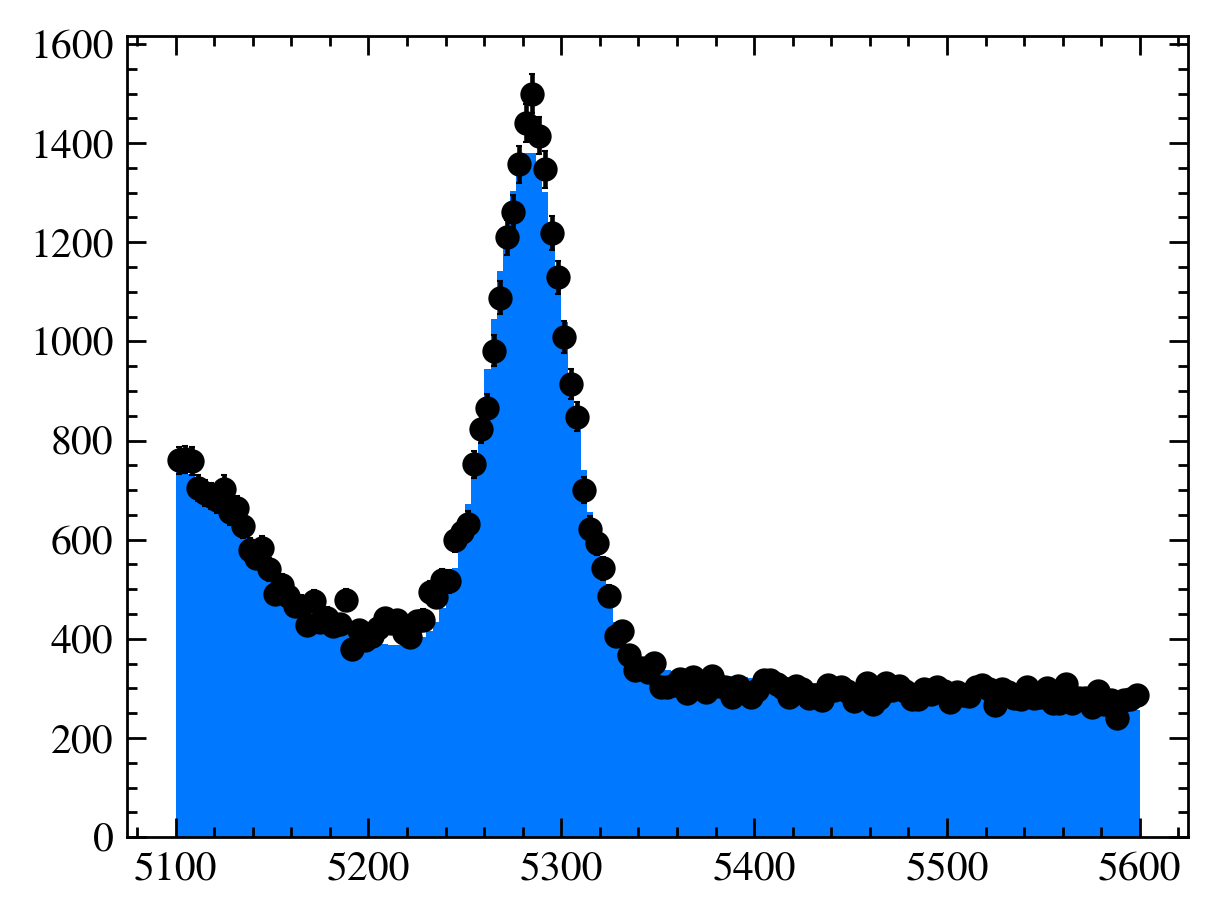

In [100]:
n_plus_gauss_linear.hesse()

In [106]:
array_of_p0_linear_background = np.array([n_plus_gauss_linear.values['signal_mu'],
                                            n_plus_gauss_linear.values['signal_sigma'],                                 
                                            n_plus_gauss_linear.values['signal_norm'],
                                            n_plus_gauss_linear.values['partial_mu'],
                                            n_plus_gauss_linear.values['partial_sigma'],
                                            n_plus_gauss_linear.values['partial_norm'],
                                            n_plus_gauss_linear.values['a'],
                                            n_plus_gauss_linear.values['b'],
                                            n_plus_gauss_linear.values['lin_norm'],
                                            n_plus_gauss_linear.values['total_norm'],
                                            ])

epsilon = 10

lower_array = array_of_p0_linear_background - epsilon
upper_array = array_of_p0_linear_background + epsilon


#set the lower array and upper array bounds for linear function
lower_array[6] = -0.2
upper_array[6] = 0.2

lower_array[2] = 0
upper_array[2] = 1e4

lower_array[5] = 0
upper_array[5] = 1e9


lower_array[7] = 0
upper_array[7] = 1e3

lower_array[8] = 0
upper_array[8] = 1e1

lower_array[9] = 0
upper_array[9] = 1e1



In [107]:
array_of_p0_linear_background

array([ 5.28342306e+03,  2.03235236e+01,  1.60026045e+03,  5.10000000e+03,
        3.84418057e+01,  4.79316595e+02, -4.29823623e-02,  2.74767784e+02,
        2.29816077e-01,  9.80865306e+00])

In [108]:
#print array lower and upper bounds in a nice format
for i in range(len(lower_array)):
    #print the lower and upper bounds and the array of p0 in one line
    print("lower bound: ", lower_array[i], "upper bound: ", upper_array[i], "p0: ", array_of_p0_linear_background[i])

lower bound:  5273.423056808985 upper bound:  5293.423056808985 p0:  5283.423056808985
lower bound:  10.3235235963703 upper bound:  30.3235235963703 p0:  20.3235235963703
lower bound:  0.0 upper bound:  10000.0 p0:  1600.260451723081
lower bound:  5090.000000000208 upper bound:  5110.000000000208 p0:  5100.000000000208
lower bound:  28.441805702299057 upper bound:  48.44180570229906 p0:  38.44180570229906
lower bound:  0.0 upper bound:  1000000000.0 p0:  479.3165954497591
lower bound:  -0.2 upper bound:  0.2 p0:  -0.04298236226859938
lower bound:  0.0 upper bound:  1000.0 p0:  274.7677841295888
lower bound:  0.0 upper bound:  10.0 p0:  0.22981607654216468
lower bound:  0.0 upper bound:  10.0 p0:  9.808653059603435


In [109]:


def fit_curve_bounds(data, p0_vals, lower_bound, upper_bound):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA

    popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals,
                               bounds=(lower_bound, upper_bound))
    plt.clf()
    return popt, pcov

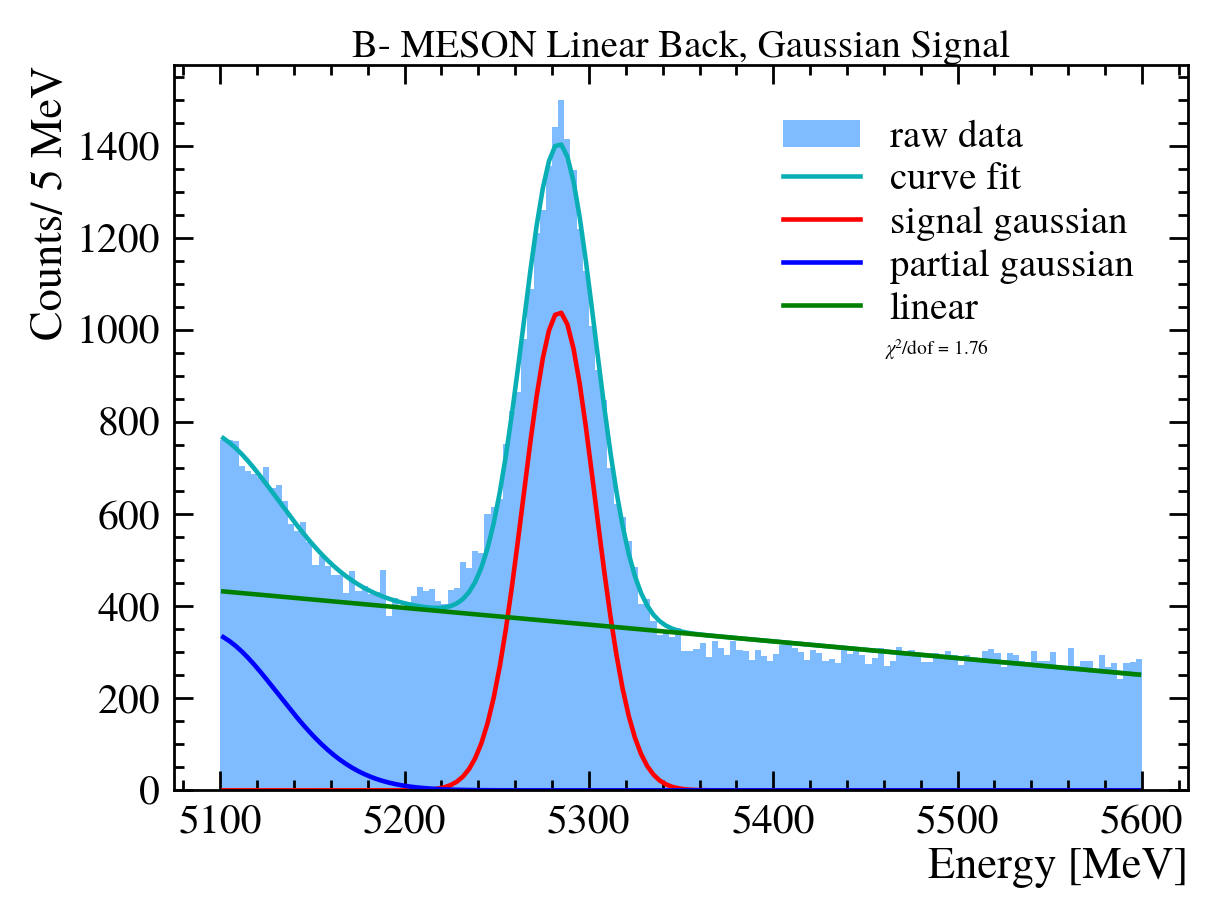

In [110]:

popt, pcov = fit_curve_bounds(data_plus, array_of_p0_linear_background, lower_array, upper_array)
#trying with bounds 



#plot the data
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

#calculate the fit
signal_gaussian = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2] * popt[-1]
partial_gaussian = halfnorm.pdf(bin_centers, popt[3], popt[4]) * popt[5] * popt[-1]
linear = linear_function(bin_centers, popt[6], popt[7]) * popt[-2] * popt[-1]

total_signal_gausain_lin = signal_gaussian + partial_gaussian + linear
pure_signal_gaussian_lin = total_signal_gausain_lin - partial_gaussian - linear

#plot the fit
plt.plot(bin_centers, fit_gaussian_lin(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, signal_gaussian, label="signal gaussian", color="red")
plt.plot(bin_centers, partial_gaussian, label="partial gaussian", color="blue")
plt.plot(bin_centers, linear, label="linear", color="green")

#add labels
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_gaussian_lin(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 1
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)

#increase size of text
#add title
plt.title("B- MESON Linear Back, Gaussian Signal")

plt.legend()

Number of events:  51004.15561605803


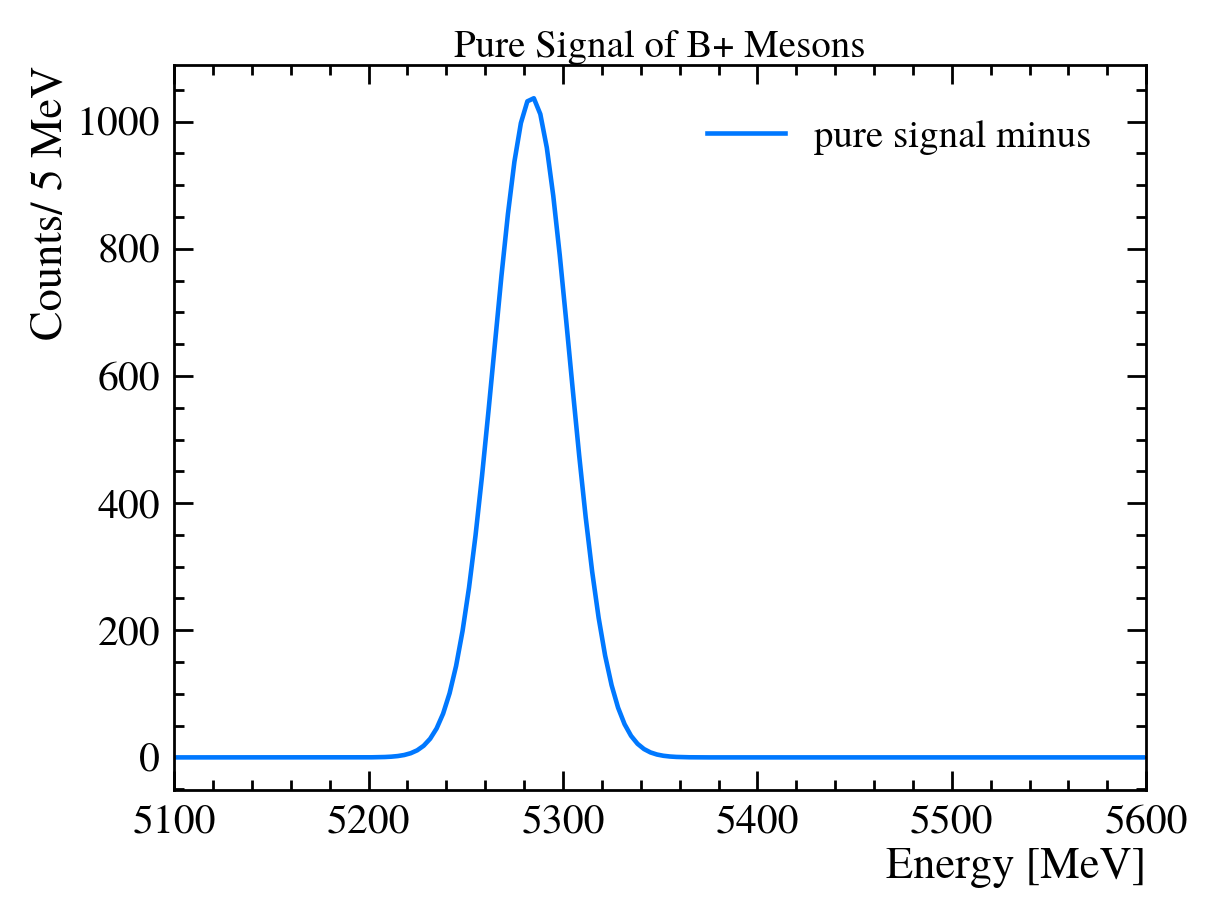

In [111]:
plt.figure()
plt.plot(bin_centers, pure_signal_gaussian, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B+ Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_lin = np.trapz(pure_signal_gaussian_lin, bin_centers)
print("Number of events: ", number_of_events_lin)